<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/fourier_cropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* Demonstrate Fourier filtering

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def doplt(arr): return(plt.imshow(arr,cmap='gray'))

# Setup

The fastest library for doing Fourier transforms is fftw

In [2]:
!pip install pyfftw
!pip install mrcfile
import mrcfile

     |████████████████████████████████| 2.6MB 4.2MB/s 
     |████████████████████████████████| 51kB 3.2MB/s 


My own Fourier code

In [8]:
!rm fourier.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/fourier.py
import fourier

rm: cannot remove 'fourier.py': No such file or directory
--2021-04-17 14:38:27--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/fourier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2659 (2.6K) [text/plain]
Saving to: ‘fourier.py’

fourier.py          100%[===================>]   2.60K  --.-KB/s    in 0s      

2021-04-17 14:38:27 (43.7 MB/s) - ‘fourier.py’ saved [2659/2659]



`coords` wraps `np.meshgrid` and `coords.coords_n_by_d` gives back the cartesean coordinates of a pixel/voxel.

In [ ]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
import coords

--2021-04-16 23:06:22--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2483 (2.4K) [text/plain]
Saving to: ‘coords.py’

coords.py           100%[===================>]   2.42K  --.-KB/s    in 0s      

2021-04-16 23:06:22 (46.4 MB/s) - ‘coords.py’ saved [2483/2483]



# Point cloud

In [ ]:
N=128
grid_1d = np.arange(-N//2,N//2)
xyz = coords.coords_n_by_d(grid_1d,d=3)

(3, 100)

Now let's make a random point cloud

In [ ]:
np.random.seed(4)
pad = 0.2*N
n_atoms = 100
atoms = np.random.uniform(low=-N//2+pad,high=N//2-pad,size=n_atoms*3).reshape(3,n_atoms)
atoms.shape

And sample that point cloud on the 3D grid (2D projection shown)

In [ ]:
def gauss(atoms,xv,yv,zv,sigma):
  x, y, z = atoms[0,:], atoms[1,:], atoms[2,:]
  r2 = (xv.reshape(-1,N,N,N)-x.reshape(-1,1,1,1))**2
  r2 += (yv.reshape(-1,N,N,N)-y.reshape(-1,1,1,1))**2
  r2 += (zv.reshape(-1,N,N,N)-z.reshape(-1,1,1,1))**2
  a = -0.5/sigma**2
  g = np.exp(a*r2).sum(0)
  return(g)
xv,yv,zv = np.meshgrid(grid_1d,grid_1d,grid_1d)



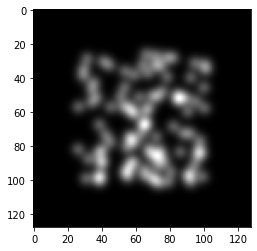

In [ ]:
g = gauss(atoms,xv,yv,zv,sigma=3)
doplt(g.sum(-1))

I wrote some code to do Fourier transforms that are centred at the origin. They are based on the convention where the real space pixels are from [-N/2, -N/2+1,..., -1, 0, +1, +2, ..., N-2, N-1], which has length N. This "centres" things, where the first half is from [-N/2, ...,  -1], and the second half is from [0, ..., N-1]. In Fourier space, this makes the "DC" pixel be the first one in the second half.

In general because of the way the fast fourier transform factorizes / is recursive, it's fast when there is a prime factorization of the number of pixels (so not a large prime number). It can be faster to pad to a factor of $2^n$, for instance if we have 127 to pad to 128. Or to pad 109 or 113 to 128.

The Fourier transform of the full sized 3D volume only needs to be computed once. Then it can be stored, and filtered versions (at better and better resolution) can be computed as needed with the inverse Fourier transform.

In [ ]:
g_f = fourier.do_fft(g,d=3)

For example if we want to have half the resolution we can "Fourier crop" by only transforming back half the pixels (centering at the origin properly).

In [ ]:
N_crop = N//2
g_crop = fourier.do_ifft(g_f[s:e,s:e,s:e])

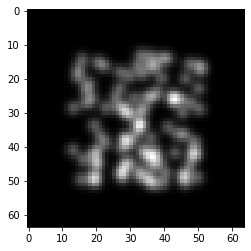

In [ ]:
doplt(g_crop.sum(-1))

The above result would be the same as doing real space pooling. However if we want to do this at different resolutions, we would have to recompute things again and again. Instead, we can just crop the precomputed Fourier volume at different levels and take the iFFT.

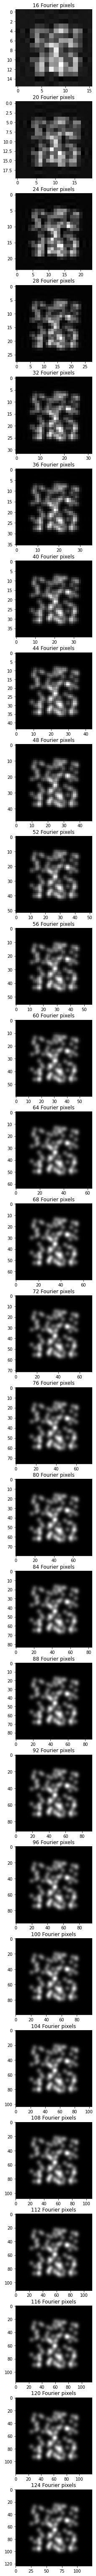

In [ ]:
N_crops = [4*n for n in range(4, np.int32(N/4))]
fig,axes = plt.subplots(nrows=len(N_crops),figsize=(36, 4*len(N_crops)))

for idx, N_crop in enumerate(N_crops):
  s,e = N//2-N_crop//2, N//2+N_crop//2
  g_crop = fourier.do_ifft(g_f[s:e,s:e,s:e])
  axes[idx].imshow(g_crop.sum(-1),cmap='gray') ; axes[idx].set_title('%i pixels'%N_crop)


# Map from EMDB

In [1]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-8450/map/emd_8450.map.gz

--2021-04-17 14:34:31--  ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-8450/map/emd_8450.map.gz
           => ‘emd_8450.map.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.197.74|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/emdb/structures/EMD-8450/map ... done.
==> SIZE emd_8450.map.gz ... 104651210
==> PASV ... done.    ==> RETR emd_8450.map.gz ... done.
Length: 104651210 (100M) (unauthoritative)

emd_8450.map.gz     100%[===================>]  99.80M  12.3MB/s    in 9.9s    

2021-04-17 14:34:44 (10.1 MB/s) - ‘emd_8450.map.gz’ saved [104651210]



In [3]:
!gunzip emd_8450.map.gz

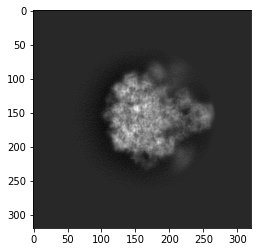

In [6]:
fname = 'emd_8450.map'
map_mrc = mrcfile.open(fname)
map_original = map_mrc.data
N = map_original.shape[0]
psize_original = map_mrc.voxel_size.item(0)[0]
psize = psize_original
doplt(map_original.sum(0))

In [19]:
map_f = fourier.do_fft(map_original,d=3)

[64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304]

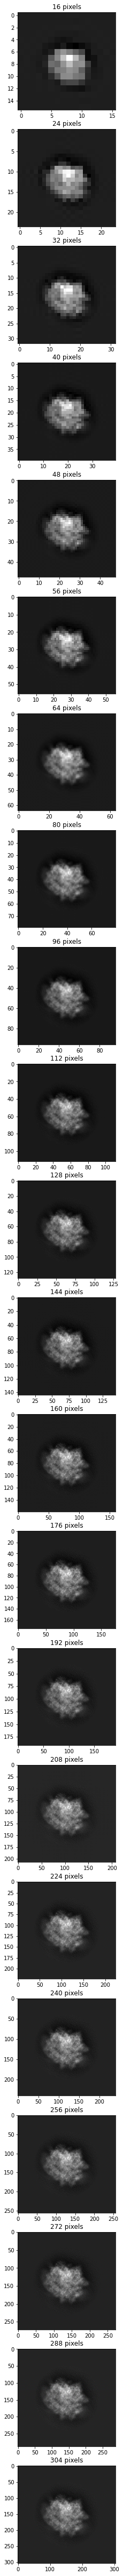

In [24]:
diff_pix_low=8
diff_pix_high=16
N_crops = [x for x in range(16,4*diff_pix_high,diff_pix_low)]+[diff_pix_high*n for n in range(4, np.int32(N/diff_pix_high))]
fig,axes = plt.subplots(nrows=len(N_crops),figsize=(36, 4*len(N_crops)))

for idx, N_crop in enumerate(N_crops):
  s,e = N//2-N_crop//2, N//2+N_crop//2
  map_crop = fourier.do_ifft(map_f[s:e,s:e,s:e])
  axes[idx].imshow(map_crop.sum(-1),cmap='gray') ; axes[idx].set_title('%i pixels'%N_crop)

In [31]:
times = []
for N_crop in N_crops:
    s,e = N//2-N_crop//2, N//2+N_crop//2
    time = %timeit -o fourier.do_ifft(map_f[s:e,s:e,s:e])
    times.append(time.best)

The slowest run took 8.19 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 238 µs per loop
1000 loops, best of 5: 699 µs per loop
1000 loops, best of 5: 1.36 ms per loop
100 loops, best of 5: 5.19 ms per loop
100 loops, best of 5: 6.11 ms per loop
100 loops, best of 5: 10.7 ms per loop
100 loops, best of 5: 14.5 ms per loop
10 loops, best of 5: 41.6 ms per loop
10 loops, best of 5: 65.2 ms per loop
10 loops, best of 5: 84.7 ms per loop
10 loops, best of 5: 110 ms per loop
1 loop, best of 5: 217 ms per loop
1 loop, best of 5: 286 ms per loop
1 loop, best of 5: 357 ms per loop
1 loop, best of 5: 571 ms per loop
1 loop, best of 5: 616 ms per loop
1 loop, best of 5: 801 ms per loop
1 loop, best of 5: 1.02 s per loop
1 loop, best of 5: 1.54 s per loop
1 loop, best of 5: 2.01 s per loop
1 loop, best of 5: 1.85 s per loop
1 loop, best of 5: 2.83 s per loop


Benchmarking shows that the 3D iFFT is < 10 ms until a pixel size of N ~ 48-56, 100 ms N ~ 112-128, and then < 1 s until N ~ 224-240 

In [37]:
ms_per_s=1000
print('num_pixels, ms')
sr*ms_per_s

num_pixels, ms


16        0.238126
24        0.698693
32        1.360654
40        5.193793
48        6.109323
56       10.704914
64       14.505750
80       41.604882
96       65.205397
112      84.650969
128     109.762258
144     216.597574
160     286.023965
176     356.591740
192     570.666559
208     616.284990
224     800.620517
240    1019.734222
256    1535.197837
272    2005.986329
288    1854.896348
304    2828.011379
dtype: float64

Text(0, 0.5, '%timeit (ms)')

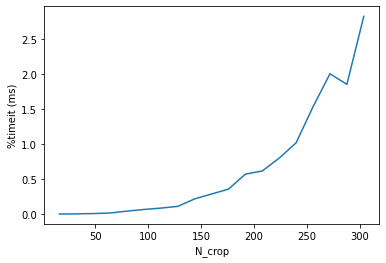

In [33]:

sr = pd.Series(times)
sr.index = N_crops
sr.plot()
plt.xlabel('N_crop')
plt.ylabel('%timeit (ms)')